<a href="https://colab.research.google.com/github/rpujala/machine_learning/blob/main/Inventory_Stockout_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

* The supply chain operations team at a global manufacturing company frequently faces unexpected SKU stockouts at regional warehouses. These stockouts cause delayed shipments, expedited freight costs, and customer dissatisfaction.

* To proactively mitigate this, the team wants a machine learning system that can **predict whether a given SKU is likely to stock out in the next 7 days**, allowing planners to trigger replenishment or reallocation actions in advance.

* The solution must work at SKU x warehourse x time level, handle missing operational data, and be explainable enough for planners to trust the predictions

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

n_samples = 6000
n_skus = 60
n_wh = 8

In [ ]:
data = {
    'sku_id': np.random.choice([f"sku_{i}" for i in range(n_skus)], n_samples),
    'warhouse_id': np.random.choice([f"wh_{i}" for i in range(n_wh)], n_samples),
    'on_hand_inventory': np.random.randint(0, 500, n_samples),
    'avg_daily_demand_7d': np.random.uniform(5, 50, n_samples),
    'avg_daily_demand_14d': np.random.uniform(5, 45, n_samples),
    'lead_time_days': np.random.randint(2, 21, n_samples),
    'open_purchase_orders': np.random.randint(0, 300, n_samples),
    'promotion_active': np.random.choice([0, 1], n_samples, p=[0.75, 0.25]),
    'holiday_week': np.random.choice([0, 1], n_samples, p=[0.85, 0.15])
}

df = pd.DataFrame(data=data)
df.head()

,sku_id,warhouse_id,on_hand_inventory,avg_daily_demand_7d,avg_daily_demand_14d,lead_time_days,open_purchase_orders,promotion_active,holiday_week
0,sku_38,wh_0,331,27.811855,38.290515,12,94,0,0
1,sku_51,wh_4,312,35.932546,27.952963,3,154,0,1
2,sku_28,wh_4,362,33.497757,23.640141,4,205,0,0
3,sku_14,wh_0,155,41.482430,30.465641,6,114,1,1
4,sku_42,wh_5,487,7.013815,16.918297,8,86,1,0


In [ ]:
expected_7_demand = df['avg_daily_demand_7d'] * 7

df['stockout_next_7_days'] = (
    (df['on_hand_inventory'] + df['open_purchase_orders']) < expected_7_demand
    ).astype(int)

df.head()

,sku_id,warhouse_id,on_hand_inventory,avg_daily_demand_7d,avg_daily_demand_14d,lead_time_days,open_purchase_orders,promotion_active,holiday_week,stockout_next_7_days
0,sku_38,wh_0,331,27.811855,38.290515,12,94,0,0,0
1,sku_51,wh_4,312,35.932546,27.952963,3,154,0,1,0
2,sku_28,wh_4,362,33.497757,23.640141,4,205,0,0,0
3,sku_14,wh_0,155,41.482430,30.465641,6,114,1,1,1
4,sku_42,wh_5,487,7.013815,16.918297,8,86,1,0,0


# Check for blank values

In [ ]:
import numpy as np

df.replace('', np.nan, inplace=True)
df.isna().sum()

sku_id                  0
warhouse_id             0
on_hand_inventory       0
avg_daily_demand_7d     0
avg_daily_demand_14d    0
lead_time_days          0
open_purchase_orders    0
promotion_active        0
holiday_week            0
stockout_next_7_days    0
dtype: int64

# Feature / Target split

In [ ]:
df.head()

,sku_id,warhouse_id,on_hand_inventory,avg_daily_demand_7d,avg_daily_demand_14d,lead_time_days,open_purchase_orders,promotion_active,holiday_week,stockout_next_7_days
0,sku_38,wh_0,331,27.811855,38.290515,12,94,0,0,0
1,sku_51,wh_4,312,35.932546,27.952963,3,154,0,1,0
2,sku_28,wh_4,362,33.497757,23.640141,4,205,0,0,0
3,sku_14,wh_0,155,41.482430,30.465641,6,114,1,1,1
4,sku_42,wh_5,487,7.013815,16.918297,8,86,1,0,0


In [ ]:
X = df.drop(columns=['sku_id', 'warhouse_id', 'stockout_next_7_days'], axis=1)
y = df['stockout_next_7_days']

In [ ]:
X[:2]

,on_hand_inventory,avg_daily_demand_7d,avg_daily_demand_14d,lead_time_days,open_purchase_orders,promotion_active,holiday_week
0,331,27.811855,38.290515,12,94,0,0
1,312,35.932546,27.952963,3,154,0,1


In [ ]:
y[:2]

0    0
1    0
Name: stockout_next_7_days, dtype: int64

# Preprocessing Pipeline (Production - Grade)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
df.head()

,sku_id,warhouse_id,on_hand_inventory,avg_daily_demand_7d,avg_daily_demand_14d,lead_time_days,open_purchase_orders,promotion_active,holiday_week,stockout_next_7_days
0,sku_38,wh_0,331,27.811855,38.290515,12,94,0,0,0
1,sku_51,wh_4,312,35.932546,27.952963,3,154,0,1,0
2,sku_28,wh_4,362,33.497757,23.640141,4,205,0,0,0
3,sku_14,wh_0,155,41.482430,30.465641,6,114,1,1,1
4,sku_42,wh_5,487,7.013815,16.918297,8,86,1,0,0


In [ ]:
num_features = [
    'on_hand_inventory',
    'avg_daily_demand_7d',
    'avg_daily_demand_14d',
    'lead_time_days',
    'open_purchase_orders'
]

cat_features = [
    'promotion_active',
    'holiday_week'
]

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_features),
    ('cat_pipeline', cat_pipeline, cat_features)
])

preprocessor

,transformers,"[('num_pipeline', ...), ('cat_pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


# Train / Test split

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                 y_train,
                                                 test_size=0.2,
                                                 random_state=42,
                                                 stratify=y_train)

In [ ]:
X_train.shape, y_train.shape

((3840, 7), (3840,))

In [ ]:
X_test.shape, y_test.shape

((1200, 7), (1200,))

In [ ]:
X_val.shape, y_val.shape

((960, 7), (960,))

# Transform Data for TensorFlow

In [ ]:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
type(X_train_processed), type(X_val_processed), type(X_test_processed)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

# TensorFlow Sequential Model (Binary Classifier)

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train_processed.shape[1], ),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate = 0.96,
    staircase=True)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics = [tf.keras.metrics.BinaryAccuracy(),
              tf.keras.metrics.AUC(name='auc')]
)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 64)                640       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dense_41 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


# Model Training

In [ ]:
import os
from datetime import datetime

log_dir = "logs/fit/" + datetime.now().strftime('%Y%m%d-%H%M%S')

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="myModel_{epoch:02d}",
        save_best_only=True,
        monitor='val_loss',
        verbose=2),

    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=5,
        verbose=2),

    tf.keras.callbacks.TensorBoard(
        log_dir = log_dir,
        histogram_freq = 1)
]

model.fit(
    X_train_processed,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/5

Epoch 1: val_loss improved from inf to 0.07272, saving model to myModel_01
INFO:tensorflow:Assets written to: myModel_01/assets
96/96 - 1s - loss: 0.1097 - binary_accuracy: 0.9642 - auc: 0.9861 - val_loss: 0.0727 - val_binary_accuracy: 0.9648 - val_auc: 0.9975 - 925ms/epoch - 10ms/step
Epoch 2/5

Epoch 2: val_loss improved from 0.07272 to 0.04290, saving model to myModel_02
INFO:tensorflow:Assets written to: myModel_02/assets
96/96 - 1s - loss: 0.1063 - binary_accuracy: 0.9723 - auc: 0.9843 - val_loss: 0.0429 - val_binary_accuracy: 0.9831 - val_auc: 0.9982 - 896ms/epoch - 9ms/step
Epoch 3/5

Epoch 3: val_loss did not improve from 0.04290
96/96 - 0s - loss: 0.2942 - binary_accuracy: 0.9567 - auc: 0.9767 - val_loss: 0.0842 - val_binary_accuracy: 0.9674 - val_auc: 0.9950 - 359ms/epoch - 4ms/step
Epoch 4/5

Epoch 4: val_loss improved from 0.04290 to 0.04101, saving model to myModel_04
INFO:tensorflow:Assets written to: myModel_04/assets
96/96 - 1s - loss: 0.1092 - binary_accurac

# Evaluation

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_probs = model.predict(X_test_processed).flatten()
y_pred_probs[:5]

38/38 [==============================] - 0s 1ms/step


array([ 2.9263506, -3.004033 , -2.042112 ,  1.265391 , -3.7031558],
      dtype=float32)

In [ ]:
y_pred_probs[:5]

array([ 2.9263506, -3.004033 , -2.042112 ,  1.265391 , -3.7031558],
      dtype=float32)

In [ ]:
pred_labels = (y_pred_probs > 0.5).astype(int)
pred_labels[:5]

array([1, 0, 0, 1, 0])

In [ ]:
print(f"Classification Report: {classification_report(y_test, pred_labels)}")

Classification Report:               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1015
           1       0.94      0.91      0.93       185

    accuracy                           0.98      1200
   macro avg       0.96      0.95      0.96      1200
weighted avg       0.98      0.98      0.98      1200



In [ ]:
print(f"ROC-AUC: {roc_auc_score(y_test, pred_labels)}")

ROC-AUC: 0.9518306483823725


# Feature Importances

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.base import is_classifier # Import check utility

# 1. Put ClassifierMixin FIRST
class KerasClassifierWrapper(ClassifierMixin, BaseEstimator):
    # 2. Define this at the CLASS level to satisfy all sklearn inspectors
    _estimator_type = "classifier"

    def __init__(self, model):
        self.model = model
        self.classes_ = np.array([0, 1])

    def fit(self, X, y):
        return self

    def predict(self, X):
        probs = self.model.predict(X, verbose=0).flatten()
        return (probs > 0.5).astype("int32")

    def predict_proba(self, X):
        prob_pos = self.model.predict(X, verbose=0).flatten()
        prob_neg = 1.0 - prob_pos
        return np.column_stack([prob_neg, prob_pos])

# --- Re-instantiate and Verify ---

wrapped_model = KerasClassifierWrapper(model)

# DEBUG: Verify sklearn sees it as a classifier BEFORE running the heavy task
print(f"Is classifier? {is_classifier(wrapped_model)}")
# This MUST print 'True'. If it prints 'False', the error will persist.

if is_classifier(wrapped_model):
    print("Starting permutation importance...")
    result = permutation_importance(
        estimator=wrapped_model,
        X=X_train_processed,
        y=y_train,
        n_repeats=5,
        scoring='roc_auc',
        random_state=42,
        n_jobs=1
    )

    print("Feature Importances computed successfully:")
    print(result.importances_mean)
else:
    print("STOP: Scikit-learn still thinks this is a Regressor. Check inheritance.")

Feature Importances computed successfully
[ 0.15738239  0.08284302 -0.00447314 -0.00263097  0.08562884  0.01994545
  0.02499168  0.00704246  0.00902047]


New feature names (9): ['num_pipeline__on_hand_inventory' 'num_pipeline__avg_daily_demand_7d'
 'num_pipeline__avg_daily_demand_14d' 'num_pipeline__lead_time_days'
 'num_pipeline__open_purchase_orders' 'cat_pipeline__promotion_active_0'
 'cat_pipeline__promotion_active_1' 'cat_pipeline__holiday_week_0'
 'cat_pipeline__holiday_week_1']


<Axes: >

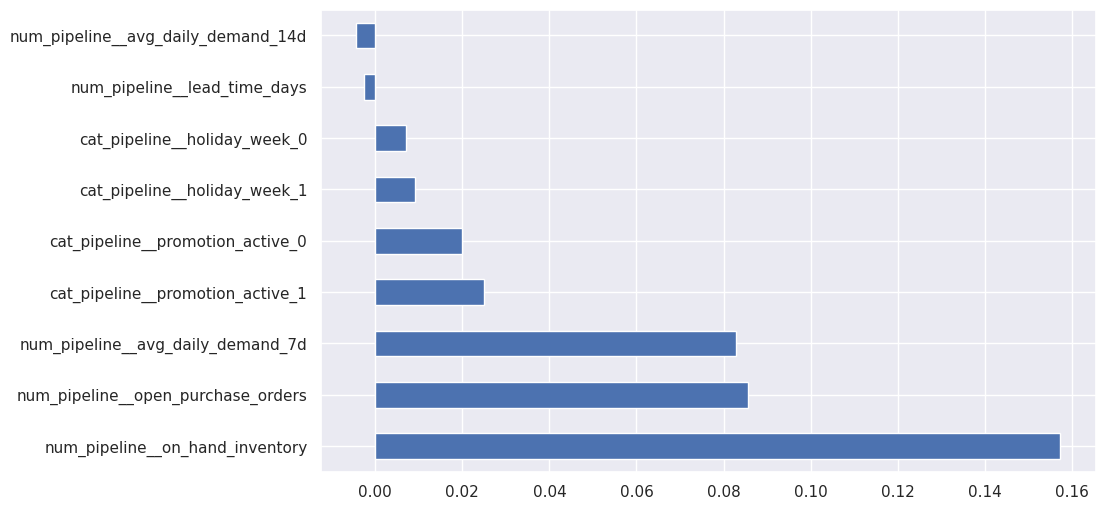

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Assuming your preprocessor is named 'preprocessor'
new_feature_names = preprocessor.get_feature_names_out()

print(f"New feature names ({len(new_feature_names)}): {new_feature_names}")

# Now plot with the correct names
importance_df = pd.Series(result.importances_mean, index=new_feature_names)
sorted_importance = importance_df.sort_values(ascending=False)
sorted_importance.plot(kind='barh', figsize=(10, 6))

In [ ]:
sorted_importance

num_pipeline__on_hand_inventory       0.157382
num_pipeline__open_purchase_orders    0.085629
num_pipeline__avg_daily_demand_7d     0.082843
cat_pipeline__promotion_active_1      0.024992
cat_pipeline__promotion_active_0      0.019945
cat_pipeline__holiday_week_1          0.009020
cat_pipeline__holiday_week_0          0.007042
num_pipeline__lead_time_days         -0.002631
num_pipeline__avg_daily_demand_14d   -0.004473
dtype: float64